In [3]:
import numpy as np
import pandas as pd
import matplotlib as plt #ne pas semettre
import seaborn as sns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import re
import nltk
import spacy
import gensim
from nltk.corpus import stopwords

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

import pickle
import unidecode
import collections

# Titles et Tags initiaux

In [88]:
#df1
post_df= pd.read_csv("Posts.csv").dropna(subset=['Title', 'Tags'])
df1 = post_df[(post_df["AnswerCount"].abs() > 10) & \
            (post_df["FavoriteCount"].abs() >  200) & \
            (post_df["ViewCount"].abs() > 5000)   & \
            (post_df["Score"].abs() > 15)]
#df2
PostsWithDeleted_df= pd.read_csv("PostsWithDeleted.csv").dropna(subset=['Title', 'Tags'])
df2 = PostsWithDeleted_df[(PostsWithDeleted_df["AnswerCount"].abs() > 10) & \
            (PostsWithDeleted_df["FavoriteCount"].abs() >  200) & \
            (PostsWithDeleted_df["ViewCount"].abs() > 5000)   & \
            (PostsWithDeleted_df["Score"].abs() > 15)]
#df3
df3= pd.read_csv("SuggestedEdits.csv").dropna(subset=['Title', 'Tags'])

#df4
df4= pd.read_csv("TagSynonyms.csv").dropna(subset=['SourceTagName', 'TargetTagName'])
df4 = df4.rename(columns={"TargetTagName": "New_Tags"})

#concat
df = pd.concat([df1[["Title", "Tags"]], df2[["Title", "Tags"]],df3[["Title", "Tags"]]])
df["Tags"] = df["Tags"].astype(str)
df = df.reset_index(drop=True)


print(df.shape)




df = df.dropna(axis=0)
print(df.shape)
df["Tags"] = df["Tags"].astype(str)

#tags to list of words
liste = []
def liste_tags(string_to_change):
    
    for element in string_to_change:
        #drop the tags < >
        test = re.sub('><|<|>', ' ', element)
 
        #string to list of strings
        str_to_list = test.split()
        
        #list of lists of tags
        liste.append(str_to_list)

        
    l = pd.Series(liste)
    #s = s.astype(str)
        
    return l

df["Tags_List"] = liste_tags (df["Tags"])
df = df.drop(labels=['Tags'], axis=1)

#replace string java
for a in df["Tags_List"]:
    for n, i in enumerate(a):
        if i == "java":
            a[n] = "javascript"
            
liste = df["Tags_List"].to_list()
tags_flat = [item for sublist in liste for item in sublist]
#counts tags
counter=collections.Counter(tags_flat)
dictionary=dict(counter)
df_tags_counts = pd.DataFrame(dictionary.items(), columns=['Tags', 'Counts'])
df_tags_counts = df_tags_counts.sort_values(by=['Counts'], ascending=False)
#select 100 most frequent tags
tags_to_keep = df_tags_counts.iloc[0:100]#df
tags_keeped = tags_to_keep["Tags"]
list_tags_keeped =tags_keeped.to_list()
#select tags in the 100 most frequent tags
df['Tags_List'] = [[y for y in x if y in list_tags_keeped] for x in df['Tags_List']]

df.head()

(2015, 2)
(2015, 2)


,Title,Tags_List
0,How do I calculate someone's age based on a Da...,"[c#, .net, datetime]"
1,Calculate relative time in C#,"[c#, datetime]"
2,Versioning SQL Server database,"[sql-server, database, svn, version-control]"
3,How do you make sure email you send programmat...,[email]
4,The definitive guide to form-based website aut...,"[http, language-agnostic]"


# Normalisation des Titles

In [89]:
#TOKENIZER
data = df.Title.values.tolist()

def sent_to_words(sentences):
    
    '''
    sentences : list of sentences
    '''
    
    sentences = [re.sub(r"\'|/|<|>", " ", sent) for sent in sentences]
    sentences = [re.sub(r"#", 'diese', sent) for sent in sentences]
    sentences = [re.sub(r"\+", 'plus', sent) for sent in sentences]
    
   
    for sentence in sentences:
                
        # deacc= True removes punctuations
        #lowercase
        #remove one caracter only
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

#data_words = list(sent_to_words(data))
#data_words #> List of list of words

In [90]:
#STOPWORDS
nltk.corpus.stopwords.words('english')

def stop_words(texts):
    '''
    texts : list of words - data_words
    corpus: list of sentences
    '''

    corpus = []
    for i in range(0,len(texts)):
        title = texts[i]
        #review = review.split() #list of words
        title = [word for word in title if not word in set(stopwords.words('english'))]
        title = ' '.join(title) #list of words to one sentence
        corpus.append(title)
        
    return corpus   

#stop_words(data_words)      #> list of sentences

In [91]:
#LEMMATIZATION
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
                   #data_words
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']): 
    '''
    texts : list of words
    '''
    texts_out = []
    for sent in texts:
        #words to sentence
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

#lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB'])

In [92]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

data = df.Title.values.tolist()

def clean_titles(text, nlp=nlp):
    global sent_to_words
    global lemmatization
    '''
    text : list of sentence(s)
    '''

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text)) #> list of words
    
    #Step1_0 : stopwords
    mytext_3 = stop_words(mytext_2) #> list of sentences
    
    # Step 2: Lemmatize      
    liste=[]

    for element in mytext_3:
        title = element.split()
        liste.append(title)
        
        mytext_3 = liste #> list of words
        
                            #mytext_2 = data_words
    mytext_4 = lemmatization(mytext_3, allowed_postags=['NOUN', 'ADJ', 'VERB']) #> list of sentences

    #mytext_5 = count_SVD_vectorizer.transform(mytext_4)
    
    
    return mytext_4

clean_titles(data, nlp=nlp)

['calculate age base datetime type birthday',
 'calculate relative time cdiese',
 'versione server database',
 'make sure email send mark spam',
 'definitive guide form base website authentication',
 'use itertool groupby',
 'well subversion',
 'add method exist object instance',
 'good technology podcast',
 'learn compiler',
 'single influential book programmer read',
 'mvp mvc difference',
 'call shell command',
 'disable browser web form field input tag',
 'scrape',
 'create executable cross platform app use python',
 'inversion control',
 'call function module use name string',
 'good way teach beginner program',
 'big calculate approximate',
 'store image yea nay',
 'good net profiler',
 'recommend font program',
 'length javascript object',
 'reset hard head',
 'barrier understand pointer do overcome',
 'difference string string cdiese',
 'good practice secure rest api web service',
 'database table column name convention',
 'flag enum attribute mean cdiese',
 'practical non imag

In [185]:
#list to series
series = pd.Series(clean_titles(data, nlp=nlp), name = "Title")
series = series.astype('str', copy=False)

#series to df["Title"]
df_cleaned = series.to_frame()
df_cleaned = df_cleaned.dropna(axis=0)
print(df_cleaned.shape)
df_cleaned.head()

(2015, 1)


,Title
0,calculate age base datetime type birthday
1,calculate relative time
2,versione server database
3,make sure email send mark spam
4,definitive guide form base website authentication


# Prediction des Tags par la LDA

In [134]:
train, test = train_test_split(df_cleaned, random_state=42, test_size=0.33, shuffle=True)

X_train = train.Title
X_test = test.Title

print(X_train.shape)
print(X_test.shape)

(1350,)
(665,)


In [135]:
X_test

1198                           error instal oracle window
526               remove padding margin datagridview cell
393                               start learn silverlight
1407                          create pdf thumbnail iphone
433                           parse local xml file io sdk
1720                             way convert map util map
1090                                                     
429                           plot move time series curve
1799                                   thread abort abort
530           texture issue draw triangale opengl android
1727                           api invalid datetime field
1453                                       implement tree
1293                             show tab widget activity
1618    use regular expression rail route make redirec...
1022                                                     
678            android screen wake timeout brightness set
1128                          load view button detailview
124           

In [136]:
from sklearn.decomposition import LatentDirichletAllocation
#Max_df=0.9 will remove words that appear in more than 90% of the reviews.
#Min_df=25 will remove words that appear in less than 25 reviews. 
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, 
                                   min_df =25, 
                                   
                                   # GridSearch: max number of uniq words 
                                   max_features=1000, 
                                   use_idf=False)

tfidf_vectorizer.fit(X_train)

feat_train = tfidf_vectorizer.transform(X_train)
feat_test = tfidf_vectorizer.transform(X_test)



'''
learning_method: if the data size is large, 
the online update will be much faster than the batch update
 '''
# Init the Model
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]} 

# Init Grid Search Class
lda = LatentDirichletAllocation(
    #The maximum number of iterations.
    max_iter=5, 
    learning_method='online', 
    #downweights early iterations in online learning.
    learning_offset=50.,
    #Pass an int for reproducible results 
    random_state=42)


model = GridSearchCV(lda, 
                     #None, to use the default 5-fold cross validation,
                     cv=None, 
                     error_score='raise',
                     n_jobs=1,
                     param_grid=search_params,
               
                     return_train_score= True)

model.fit(feat_train)
best_lda_model = model.best_estimator_
pickle.dump(best_lda_model, open('lda.pkl', 'wb'))
#best_lda_model = pickle.load(open('lda.pkl', 'rb'))


In [137]:
top_100_tags = [".net",
                  "ajax",
             "algorithm",
               "android",
             "animation",
                   "api",
                "arrays",
               "asp.net",
           "asp.net-mvc",
               "browser",
                     "c",
                    "c#",
                   "c++",
                 "class",
                 "cocoa",
           "cocoa-touch",
           "codeigniter",
           "collections",
                   "css",
              "database",
                  "date",
              "datetime",
       "design-patterns",
                "django",
               "eclipse",
                 "email",
                 "enums",
                 "error",
                 "excel",
              "facebook",
                 "forms",
                   "git",
              "gridview",
              "homework",
                  "html",
                 "html5",
                  "http",
                 "image",
                   "ios",
                 "ipad",
                "iphone",
        "iphone-sdk-3.0",
        "iphone-sdk-4.0",
            "javascript",
                "jquery",
             "jquery-ui",
                  "json",
                   "jsp",
     "language-agnostic",
                "layout",
                  "linq",
                 "linux",
              "listview",
                   "mac",
                  "math",
                "memory",
               "methods",
        "multithreading",
                 "mysql",
           "objective-c",
                   "oop",
                "oracle",
                   "pdf",
           "performance",
                  "perl",
                   "php",
                  "php5",
                "python",
                     "r",
                 "regex",
                  "ruby",
         "ruby-on-rails",
       "ruby-on-rails-3",
            "sharepoint",
           "silverlight",
                   "sql",
            "sql-server",
                "sqlite",
     "stored-procedures",
                "string",
                   "svn",
                 "swing",
                "syntax",
           "terminology",
                  "tsql",
           "uitableview",
          "unit-testing",
            "validation",
                "vb.net",
       "version-control",
    "visual-studio-2010",
                   "wcf",
       "web-development",
          "web-services",
               "windows",
              "winforms",
                   "wpf",
                 "xcode",
                   "xml",
        "zend-framework"]

In [138]:
# Get the top 10 keywords each topic

def show_topics(vectorizer=tfidf_vectorizer, lda_model=best_lda_model, n_words=20):
    keywords = np.array(tfidf_vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords


topic_keywords = show_topics(vectorizer=tfidf_vectorizer,
                             lda_model=best_lda_model, 
                             n_words=10)


# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,error,change,problem,array,table,web,work,make,php,value
Topic 1,get,value,database,change,function,string,file,problem,code,server
Topic 2,object,php,app,string,get,problem,make,database,android,file
Topic 3,query,net,function,use,page,create,application,table,javascript,object
Topic 4,create,datum,server,good,web,application,use,file,get,value
Topic 5,string,error,difference,web,file,javascript,work,use,android,datum
Topic 6,problem,class,array,javascript,text,file,object,add,work,get
Topic 7,file,iphone,table,application,user,make,app,use,web,string
Topic 8,use,android,page,code,add,web,javascript,get,application,image
Topic 9,image,work,use,difference,object,problem,web,user,file,get


In [139]:
#10 words
no_top_words = 10
tf_feature_names = tfidf_vectorizer.get_feature_names()

def display_topics(model, feature_names, no_top_words):
    #(model.components_)(10, 29)
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(best_lda_model, tf_feature_names, no_top_words)

Topic 0:
error change problem array table web work make php value
Topic 1:
get value database change function string file problem code server
Topic 2:
object php app string get problem make database android file
Topic 3:
query net function use page create application table javascript object
Topic 4:
create datum server good web application use file get value
Topic 5:
string error difference web file javascript work use android datum
Topic 6:
problem class array javascript text file object add work get
Topic 7:
file iphone table application user make app use web string
Topic 8:
use android page code add web javascript get application image
Topic 9:
image work use difference object problem web user file get


In [181]:
my_string = "error change problem array table web work make php value"
for element in my_string.split():
    if element in top_100_tags:
        print(element)

error
php


In [182]:
#Attention ... 
Topics = [
    #0 
    ["error","php","arrays","web-development", "web-services"], 
    
    #1 
    ["database", "string", "iphone"] , 
    
    #2 
    [ "php", "string","database", "android"],
    
    #3 
    [".net","javascript"],
    
    #4 
    ["web-development", "web-services"], 
    
    #5 
    ["string","error","javascript","android","web-development", "web-services"], 
    
    #6 
    ["class", "javascript","arrays"], 
    
    #7 
    ["iphone", "string" ,"web-development", "web-services" ], 
    
    #8 
    ["android",  "javascript", "image","web-development", "web-services"], 
    
    #9 
    ["image" ,"web-development", "web-services"]]

df_topic_keywords["Topics"]=Topics
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Topics
Topic 0,error,change,problem,array,table,web,work,make,php,value,"[error, php, arrays, web-development, web-serv..."
Topic 1,get,value,database,change,function,string,file,problem,code,server,"[database, string, iphone]"
Topic 2,object,php,app,string,get,problem,make,database,android,file,"[php, string, database, android]"
Topic 3,query,net,function,use,page,create,application,table,javascript,object,"[.net, javascript]"
Topic 4,create,datum,server,good,web,application,use,file,get,value,"[web-development, web-services]"
Topic 5,string,error,difference,web,file,javascript,work,use,android,datum,"[string, error, javascript, android, web-devel..."
Topic 6,problem,class,array,javascript,text,file,object,add,work,get,"[class, javascript, arrays]"
Topic 7,file,iphone,table,application,user,make,app,use,web,string,"[iphone, string, web-development, web-services]"
Topic 8,use,android,page,code,add,web,javascript,get,application,image,"[android, javascript, image, web-development, ..."
Topic 9,image,work,use,difference,object,problem,web,user,file,get,"[image, web-development, web-services]"


In [183]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#Tokenizer
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations
        
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization
    
    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
    
    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB'])  
    
    # Step 3: Our Vectorize transform
    mytext_4 = tfidf_vectorizer.transform(mytext_3)
    
    # Step 4: Our LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    
    # Step 5: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, topic_probability_scores# Predict the topic

#test predict_topic function
mytext = ["calculate relative time cdiese"]
infer_topic, topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(infer_topic)

['change', 'problem', 'array', 'table', 'web', 'work', 'make', 'php', 'value', ['error', 'php', 'arrays', 'web-development', 'web-services']]
['error', 'php', 'arrays', 'web-development', 'web-services']


In [186]:
df_cleaned.head()

,Title
0,calculate age base datetime type birthday
1,calculate relative time
2,versione server database
3,make sure email send mark spam
4,definitive guide form base website authentication


In [187]:
#Predict topics of our reviews in the original dataset:

def apply_predict_topic(text):
    text = [text]
    infer_topic, topic, prob_scores = predict_topic(text = text)
    return (infer_topic)

print(df_cleaned.shape)
df_cleaned["LDA"]= df_cleaned['Title'].apply(apply_predict_topic)
df_cleaned = df_cleaned.dropna(axis=0)
print(df_cleaned.shape)
df_cleaned.head(10)

(2015, 1)
(2015, 2)


,Title,LDA
0,calculate age base datetime type birthday,"[error, php, arrays, web-development, web-serv..."
1,calculate relative time,"[error, php, arrays, web-development, web-serv..."
2,versione server database,"[database, string, iphone]"
3,make sure email send mark spam,"[iphone, string, web-development, web-services]"
4,definitive guide form base website authentication,"[error, php, arrays, web-development, web-serv..."
5,use itertool groupby,"[android, javascript, image, web-development, ..."
6,well subversion,"[error, php, arrays, web-development, web-serv..."
7,add method exist object instance,"[php, string, database, android]"
8,good technology podcast,"[web-development, web-services]"
9,learn compiler,"[error, php, arrays, web-development, web-serv..."


# Split Final Data

In [188]:
from sklearn.preprocessing import MultiLabelBinarizer

#Dummies for Tags

s = df_cleaned['LDA']

mlb = MultiLabelBinarizer()

df_y = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df_cleaned.index)


pickle.dump(mlb, open('MultiLabelBinarizer.pkl', 'wb'))



print(df_y.shape)
df_y.head()


(2015, 13)


,.net,android,arrays,class,database,error,image,iphone,javascript,php,string,web-development,web-services
0,0,0,1,0,0,1,0,0,0,1,0,1,1
1,0,0,1,0,0,1,0,0,0,1,0,1,1
2,0,0,0,0,1,0,0,1,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0,1,1,1
4,0,0,1,0,0,1,0,0,0,1,0,1,1


In [189]:
df_cleaned = pd.concat([df_cleaned["Title"],df_y], axis = 1)
df_cleaned = df_cleaned.dropna(axis=0)
print(df_cleaned.shape)
df_cleaned.head()

(2015, 14)


,Title,.net,android,arrays,class,database,error,image,iphone,javascript,php,string,web-development,web-services
0,calculate age base datetime type birthday,0,0,1,0,0,1,0,0,0,1,0,1,1
1,calculate relative time,0,0,1,0,0,1,0,0,0,1,0,1,1
2,versione server database,0,0,0,0,1,0,0,1,0,0,1,0,0
3,make sure email send mark spam,0,0,0,0,0,0,0,1,0,0,1,1,1
4,definitive guide form base website authentication,0,0,1,0,0,1,0,0,0,1,0,1,1


In [190]:
category = list(df_y.columns)

#Split the data
train, test = train_test_split(df_cleaned, random_state=42, test_size=0.33, shuffle=True)

X_train = train.Title
X_test = test.Title

y_train = train[category]
y_test = test[category]

print(X_train.shape)
print(X_test.shape)

(1350,)
(665,)


In [192]:
y_test.head()

,.net,android,arrays,class,database,error,image,iphone,javascript,php,string,web-development,web-services
1198,0,1,0,0,0,1,0,0,1,0,1,1,1
526,0,0,1,0,0,1,0,0,0,1,0,1,1
393,0,0,1,0,0,1,0,0,0,1,0,1,1
1407,0,0,0,0,0,0,0,0,0,0,0,1,1
433,0,0,0,0,0,0,0,1,0,0,1,1,1


# Pipeline SVC


In [193]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, 
                                   min_df =25, 
                                   #GridSearch: max number of uniq words 
                                   max_features=1000, 
                                   use_idf=False)
tfidf_vectorizer.fit(X_train)
feat_train = tfidf_vectorizer.transform(X_train)
feat_test = tfidf_vectorizer.transform(X_test)

#Model
estimator = SVC(random_state= 42)
SVC_clf = OneVsRestClassifier(estimator, n_jobs=1)
params = { 'estimator__C': np.logspace(-3, 3, 7, 10) }


#train the gs model
gs = GridSearchCV(SVC_clf, params, cv=10)
gs.fit(feat_train, y_train)#time 

#train the log model
best_svc_model = gs.best_estimator_

In [194]:
from sklearn.pipeline import Pipeline



pipeline = Pipeline(
    [('count', TfidfVectorizer(max_df=0.90, 
                                   min_df =25, 
                                   #GridSearch: max number of uniq words 
                                   max_features=1000, 
                                   use_idf=False)),
    ("clf", best_svc_model),
    
    ])

In [195]:
#train and test the best_lr_model 
pipeline.fit(X_train,y_train) 
y_pred = pipeline.predict(X_test)
y_pred

array([[0, 1, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 0, 1, 1],
       [0, 0, 1, ..., 0, 1, 1],
       ...,
       [0, 1, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 0, 1, 1]])

In [196]:
#save and load the PIPELINE
pickle.dump(pipeline, open('pipeline.pkl', 'wb'))
pickled_pipeline = pickle.load(open('pipeline.pkl', 'rb'))

y_pred = pickled_pipeline.predict(X_test)
y_pred

array([[0, 1, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 0, 1, 1],
       [0, 0, 1, ..., 0, 1, 1],
       ...,
       [0, 1, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 0, 1, 1]])

In [197]:
#Dummies to series
series_tags = mlb.inverse_transform(y_pred)
print(len(series_tags))
series_tags

665


[('android',
  'error',
  'javascript',
  'string',
  'web-development',
  'web-services'),
 ('arrays', 'error', 'php', 'web-development', 'web-services'),
 ('arrays', 'error', 'php', 'web-development', 'web-services'),
 ('web-development', 'web-services'),
 ('iphone', 'string', 'web-development', 'web-services'),
 ('arrays', 'error', 'php', 'web-development', 'web-services'),
 ('arrays', 'error', 'php', 'web-development', 'web-services'),
 ('arrays', 'error', 'php', 'web-development', 'web-services'),
 ('arrays', 'error', 'php', 'web-development', 'web-services'),
 ('android', 'image', 'javascript', 'web-development', 'web-services'),
 ('arrays', 'error', 'php', 'web-development', 'web-services'),
 ('arrays', 'error', 'php', 'web-development', 'web-services'),
 ('arrays', 'error', 'php', 'web-development', 'web-services'),
 ('android', 'image', 'javascript', 'web-development', 'web-services'),
 ('arrays', 'error', 'php', 'web-development', 'web-services'),
 ('android', 'image', 'javas

In [198]:
# test the loaded model on different type of inputs
y_pred = pickled_pipeline.predict([" make service android implement broadcast reciever"])
y_pred

array([[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1]])

In [199]:
tags = mlb.inverse_transform(y_pred)
tags

[('android', 'image', 'javascript', 'web-development', 'web-services')]

# Application

In [201]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer
import numpy as np


# Creation d'un fonction de nettoyage pour l'entrée manuelle du Title
stop=nltk.corpus.stopwords.words('english')
pickle.dump(stop, open('stopwords.pkl', 'wb'))
pickledb_stop = pickle.load(open('stopwords.pkl', 'rb'))

def nettoyage(texte):
    t=[]
    texte=str(texte)
    texte=unidecode.unidecode(texte).replace('\'',' ').replace('\n',' ')
    # Je ne garde que les éléments non numériques et sans les . ,
    p='([^0-9\'".,;]{1,})'
    for elem in re.findall(p,texte):
        for el in elem.split():
            if el.lower() in stop or len(el) < 3:
                continue
            else :
                t.append(el)
    return ' '.join(t)




commentaire=str(input())
commentaire=nettoyage(commentaire)
#print(commentaire)


y_pred = pickled_pipeline.predict([commentaire])
mlb = pickle.load(open('MultiLabelBinarizer.pkl', 'rb'))
tags = mlb.inverse_transform(y_pred)
tags[0]

  hide feature asp net


('.net', 'javascript')

In [157]:
X_test

1198                           error instal oracle window
526               remove padding margin datagridview cell
393                               start learn silverlight
1407                          create pdf thumbnail iphone
433                           parse local xml file io sdk
1720                             way convert map util map
1090                                                     
429                           plot move time series curve
1799                                   thread abort abort
530           texture issue draw triangale opengl android
1727                           api invalid datetime field
1453                                       implement tree
1293                             show tab widget activity
1618    use regular expression rail route make redirec...
1022                                                     
678            android screen wake timeout brightness set
1128                          load view button detailview
124           

**<font color="green">Tout fonctionne, la prochaine étape est d'iscrire ce code dans le fichier launch_test.py. Cela va permettre d'envoyer les données et de recevoir le résultat avec Flask en pointant l'url qui est le point d'entrée de l'API.</font>**

# Usage de l'API

Sur le terminal apres installation de Flask : https://linuxize.com/post/how-to-install-flask-on-ubuntu-20-04/,


        - export FLASK_APP=launch_test.py
        - flask run
        faire attention de se situer sur le répertoire ou se situe le fichier .py
        - vérifier sur l'adresse http que tout fonctionne puis exécuter le cellules ci-dessous.
        - pour quitter : Ctrl C 



**En local:**

In [1]:
import requests
url="http://127.0.0.1:5000/result"

In [2]:
user_text = "fetch datum facebook use query string salesforce"
params={"input_text": user_text}

requests.post(url,params).json()

{'reponse': ['.net', 'javascript']}

**On peu tester avec les phrases de l'échantillon test:**

In [77]:
X_test

array(['batch append date time creation random end filename',
       'app purchasing remove iad banner ipad app',
       'pass specific attribute object store array tableview cell',
       'retrieve value array', 'compatible javascript css file',
       'get setting button display live wallpaper',
       'hide feature cplusplus', 'use enough secure query string',
       'possible filter user queue appear view assigning case',
       'mysql profile tool', 'javascript query string work',
       'grab recent search',
       'entity model issue able create model particular table',
       'alternative cursor sql loop', 'break format nsstre multiple line',
       'deploy web testing config build server',
       'ajax loading screen prototype unobtrusive',
       'run macro access web database application instance initialize',
       'email send server', 'pass dictionary string string object method',
       'dialog logout access token facebook io',
       'prevent disabled jmenuitem hiding me

**heroku - message d'erreur sur le terminal:**

In [ ]:
Pour le login :

$ git init .
$ git add app.py Procfile requirements.txt
$ git commit -m "first commit"
$ heroku login -i        
$ heroku login        
$ heroku apps
$ heroku git:remote -a YOUR_APP
    out: set git remote heroku to https://git.heroku.com/tags-heroku.git

$ git push heroku master

Heroku : https://git.heroku.com/tags-heroku.git
        
 ! [remote rejected] master -> master (pre-receive hook declined)
error: failed to push some refs to 'https://git.heroku.com/tags-heroku.git'


**pythonanywhere: panne de serveur sur pythonanywhere :**

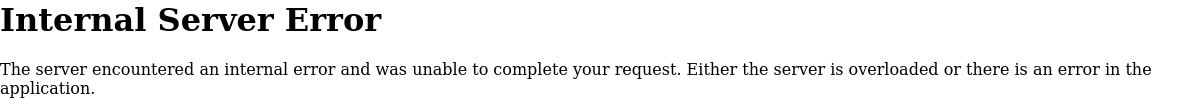

pythonanywhere: catherinele.pythonanywhere.com

**Sources:**

Installation Flask on Linux: 

https://linuxize.com/post/how-to-install-flask-on-ubuntu-20-04/

Heroku on Linux: 

https://stackabuse.com/deploying-a-flask-application-to-heroku/